# My Example Solution for DeepAR


- This project aims to predict sales for various product families sold at Favorita stores in Ecuador. By leveraging historical sales data and additional contextual information, we develop a predictive model to forecast future sales accurately. The solution involves analyzing time-series data, incorporating external factors such as promotions, holidays, and economic indicators to enhance prediction accuracy.


### Imporinting Libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from visualising import *


import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss

/home/metaphysicist/Coding/2025/Projects/Time_Series/Sales_Ecuador/.venv/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA is available! PyTorch can use your GPU.")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}") # Or whatever device index
else:
    print("CUDA is NOT available. PyTorch cannot use your GPU.")
    print("Please check your CUDA installation, GPU drivers, and PyTorch version.")

CUDA is available! PyTorch can use your GPU.
Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA GeForce GTX 1650 with Max-Q Design


### Data Loading


In [3]:
df_train = pd.read_csv('data/train.csv', index_col=0, parse_dates=True)
df_oil = pd.read_csv('data/oil.csv', index_col=0, parse_dates=True)
df_stores = pd.read_csv('data/stores.csv', index_col=0, parse_dates=True)
df_test = pd.read_csv('data/test.csv', index_col=0, parse_dates=True)
df_transactions = pd.read_csv('data/transactions.csv', index_col=0, parse_dates=True)
df_holiday = pd.read_csv('data/holidays_events.csv', index_col=0, parse_dates=True)

/tmp/ipykernel_144852/917830957.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train = pd.read_csv('data/train.csv', index_col=0, parse_dates=True)
/tmp/ipykernel_144852/917830957.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_stores = pd.read_csv('data/stores.csv', index_col=0, parse_dates=True)
/tmp/ipykernel_144852/917830957.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test = pd.read_csv('data/test.csv', index_col=0, parse_dates=True)


### Data Preprocessing


In [4]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train.set_index('date', inplace=True)

In [5]:
df_train

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0
2013-01-01,1,BABY CARE,0.000,0
2013-01-01,1,BEAUTY,0.000,0
2013-01-01,1,BEVERAGES,0.000,0
2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...
2017-08-15,9,POULTRY,438.133,0
2017-08-15,9,PREPARED FOODS,154.553,1
2017-08-15,9,PRODUCE,2419.729,148


In [6]:
df_train.describe()

,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06
mean,2.750000e+01,3.577757e+02,2.602770e+00
std,1.558579e+01,1.101998e+03,1.221888e+01
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.400000e+01,0.000000e+00,0.000000e+00
50%,2.750000e+01,1.100000e+01,0.000000e+00
75%,4.100000e+01,1.958473e+02,0.000000e+00
max,5.400000e+01,1.247170e+05,7.410000e+02


In [7]:
df_train.shape

(3000888, 4)

In [8]:
df_stores.head()

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
df_stores.shape

(54, 4)

### Data Merging


In [10]:
df_combined = df_train.merge(df_stores,how='left', left_on='store_nbr', right_index=True)

In [11]:
df_combined.shape

(3000888, 8)

In [12]:
df_combined.head()

,store_nbr,family,sales,onpromotion,city,state,type,cluster
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [13]:
df_combined.describe()

,store_nbr,sales,onpromotion,cluster
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,2.750000e+01,3.577757e+02,2.602770e+00,8.481481e+00
std,1.558579e+01,1.101998e+03,1.221888e+01,4.649735e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00
50%,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00
75%,4.100000e+01,1.958473e+02,0.000000e+00,1.300000e+01
max,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01


In [14]:
df_oil

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-08-25,47.65
2017-08-28,46.40
2017-08-29,46.46


In [15]:
df_oil.index = pd.to_datetime(df_oil.index)


In [16]:
df_combined_oil = df_combined.merge(df_oil, how='left', left_index=True, right_index=True)

In [17]:
df_combined_oil.head()

,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
date,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN
2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN
2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN
2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN
2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN


In [18]:
merged_df = df_combined_oil.merge(
    df_transactions,
    how='left',
    left_on=['date', 'store_nbr'],
    right_on=['date', 'store_nbr']
)

In [19]:
merged_df

,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions
date,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN,NaN
2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN,NaN
2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN,NaN
2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN,NaN
2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,2155.0
2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,2155.0
2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,2155.0


#### //// For this moment merged

#### train-oil-transaction-stores ---> -holiday


In [20]:
df_holiday

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


In [21]:
merged_df_final = merged_df.merge(df_holiday, how='left', left_index=True, right_index=True)

In [22]:
merged_df_final

,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,transactions,type_y,locale,locale_name,description,transferred
date,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [23]:
merged_df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3054348 entries, 2013-01-01 to 2017-08-15
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   store_nbr     int64  
 1   family        object 
 2   sales         float64
 3   onpromotion   int64  
 4   city          object 
 5   state         object 
 6   type_x        object 
 7   cluster       int64  
 8   dcoilwtico    float64
 9   transactions  float64
 10  type_y        object 
 11  locale        object 
 12  locale_name   object 
 13  description   object 
 14  transferred   object 
dtypes: float64(3), int64(3), object(9)
memory usage: 372.8+ MB


In [24]:
merged_df_final.isna().sum()
merged_df_final.fillna(0, inplace=True)

In [25]:
categorical = merged_df_final.select_dtypes(include=['object']).columns
for col in categorical:
    val = merged_df_final[col].nunique()
    print(f"Column {col} has {val} unique values.")

Column family has 33 unique values.
Column city has 22 unique values.
Column state has 16 unique values.
Column type_x has 5 unique values.
Column type_y has 7 unique values.
Column locale has 4 unique values.
Column locale_name has 25 unique values.
Column description has 102 unique values.
Column transferred has 2 unique values.


In [26]:
merged_df_final[categorical]

,family,city,state,type_x,type_y,locale,locale_name,description,transferred
date,,,,,,,,,
2013-01-01,AUTOMOTIVE,Quito,Pichincha,D,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,BABY CARE,Quito,Pichincha,D,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,BEAUTY,Quito,Pichincha,D,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,BEVERAGES,Quito,Pichincha,D,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,BOOKS,Quito,Pichincha,D,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...
2017-08-15,POULTRY,Quito,Pichincha,B,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2017-08-15,PREPARED FOODS,Quito,Pichincha,B,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2017-08-15,PRODUCE,Quito,Pichincha,B,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [27]:
merged_df_final = merged_df_final.reset_index()

# Convert date to datetime if not already
merged_df_final['date'] = pd.to_datetime(merged_df_final['date'])

In [28]:
merged_df_final['time_idx'] = (merged_df_final['date'] - merged_df_final['date'].min()).dt.days

In [29]:
merged_df_final

,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,transactions,type_y,locale,locale_name,description,transferred,time_idx
0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,0.00,0.0,Holiday,National,Ecuador,Primer dia del ano,False,0
1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,0.00,0.0,Holiday,National,Ecuador,Primer dia del ano,False,0
2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,0.00,0.0,Holiday,National,Ecuador,Primer dia del ano,False,0
3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,0.00,0.0,Holiday,National,Ecuador,Primer dia del ano,False,0
4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,0.00,0.0,Holiday,National,Ecuador,Primer dia del ano,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1687
3054344,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1687
3054345,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1687
3054346,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1687


In [30]:
merged_df_final = merged_df_final.set_index('date')

In [31]:
encoders = {}

# Step 3: Loop through categorical columns and encode
for col in categorical:
    # Initialize encoder
    encoders[col] = NaNLabelEncoder(add_nan=True)
    # Fit and transform training data

    merged_df_final[col] = merged_df_final[col].astype(str).replace('nan', None)
    merged_df_final[f"{col}_encoded"] = encoders[col].fit_transform(merged_df_final[col])
    # Transform test data (handle unseen categories)
    print(f"{col}: is under processing")
    if col in merged_df_final.columns:
        merged_df_final[f"{col}_encoded"] = encoders[col].transform(merged_df_final.get(col, pd.Series([None] * len(merged_df_final))))
    else:
        # If column missing in test data, fill with NaN
        merged_df_final[f"{col}_encoded"] = None

family: is under processing
city: is under processing
state: is under processing
type_x: is under processing
type_y: is under processing
locale: is under processing
locale_name: is under processing
description: is under processing
transferred: is under processing


In [32]:
merged_df_final.drop(columns=categorical, inplace=True)


In [33]:
merged_df_final.tail()

,store_nbr,sales,onpromotion,cluster,dcoilwtico,transactions,time_idx,family_encoded,city_encoded,state_encoded,type_x_encoded,type_y_encoded,locale_encoded,locale_name_encoded,description_encoded,transferred_encoded
date,,,,,,,,,,,,,,,,
2017-08-15,9,438.133,0,6,47.57,2155.0,1687,29,19,13,2,5,2,21,30,2
2017-08-15,9,154.553,1,6,47.57,2155.0,1687,30,19,13,2,5,2,21,30,2
2017-08-15,9,2419.729,148,6,47.57,2155.0,1687,31,19,13,2,5,2,21,30,2
2017-08-15,9,121.000,8,6,47.57,2155.0,1687,32,19,13,2,5,2,21,30,2
2017-08-15,9,16.000,0,6,47.57,2155.0,1687,33,19,13,2,5,2,21,30,2


In [34]:
merged_df_final.describe()

,store_nbr,sales,onpromotion,cluster,dcoilwtico,transactions,time_idx,family_encoded,city_encoded,state_encoded,type_x_encoded,type_y_encoded,locale_encoded,locale_name_encoded,description_encoded,transferred_encoded
count,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06
mean,2.750000e+01,3.590209e+02,2.617480e+00,8.481481e+00,4.674603e+01,1.558656e+03,8.455082e+02,1.700000e+01,1.355556e+01,9.796296e+00,3.000000e+00,1.566511e+00,1.271295e+00,2.399650e+00,7.037923e+00,1.169778e+00
std,1.558579e+01,1.107286e+03,1.225494e+01,4.649735e+00,3.805151e+01,1.036468e+03,4.874346e+02,9.521906e+00,6.264737e+00,4.165021e+00,1.201851e+00,1.354563e+00,6.574446e-01,3.968314e+00,1.741629e+01,3.891727e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,9.310000e+02,4.240000e+02,9.000000e+00,9.000000e+00,7.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,4.702000e+01,1.332000e+03,8.475000e+02,1.700000e+01,1.500000e+01,1.100000e+01,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,4.100000e+01,1.960110e+02,0.000000e+00,1.300000e+01,9.153000e+01,1.980000e+03,1.268000e+03,2.500000e+01,1.900000e+01,1.300000e+01,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02,8.359000e+03,1.687000e+03,3.300000e+01,2.200000e+01,1.600000e+01,5.000000e+00,7.000000e+00,4.000000e+00,2.500000e+01,1.020000e+02,3.000000e+00


In [35]:
merged_df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3054348 entries, 2013-01-01 to 2017-08-15
Data columns (total 16 columns):
 #   Column               Dtype  
---  ------               -----  
 0   store_nbr            int64  
 1   sales                float64
 2   onpromotion          int64  
 3   cluster              int64  
 4   dcoilwtico           float64
 5   transactions         float64
 6   time_idx             int64  
 7   family_encoded       int64  
 8   city_encoded         int64  
 9   state_encoded        int64  
 10  type_x_encoded       int64  
 11  type_y_encoded       int64  
 12  locale_encoded       int64  
 13  locale_name_encoded  int64  
 14  description_encoded  int64  
 15  transferred_encoded  int64  
dtypes: float64(3), int64(13)
memory usage: 396.1 MB


In [36]:
num_cols_for_vis = merged_df_final.columns

### Visualising


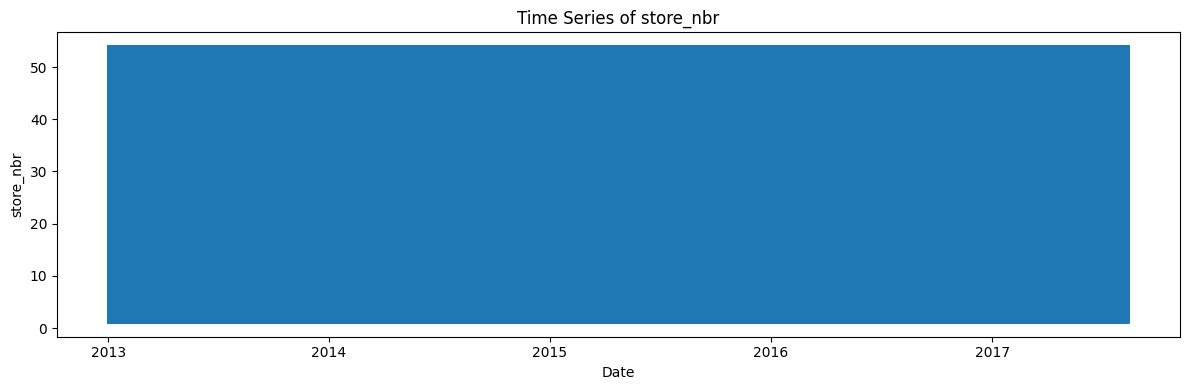

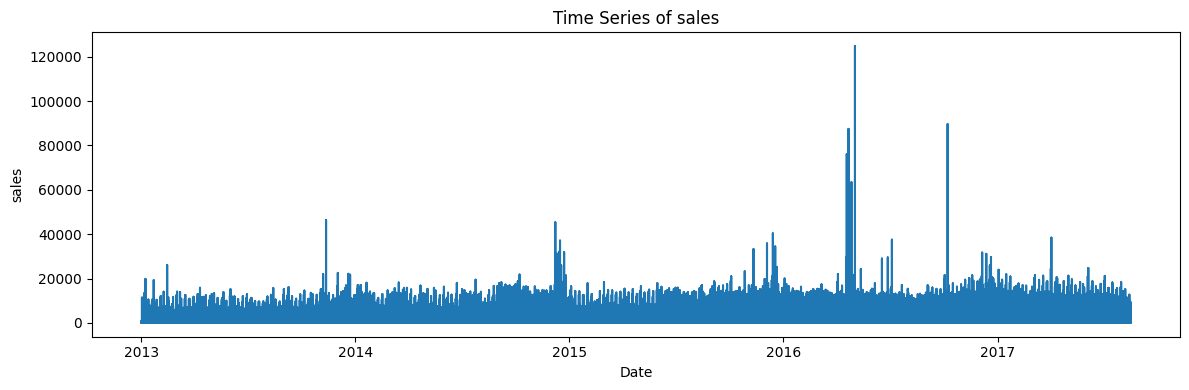

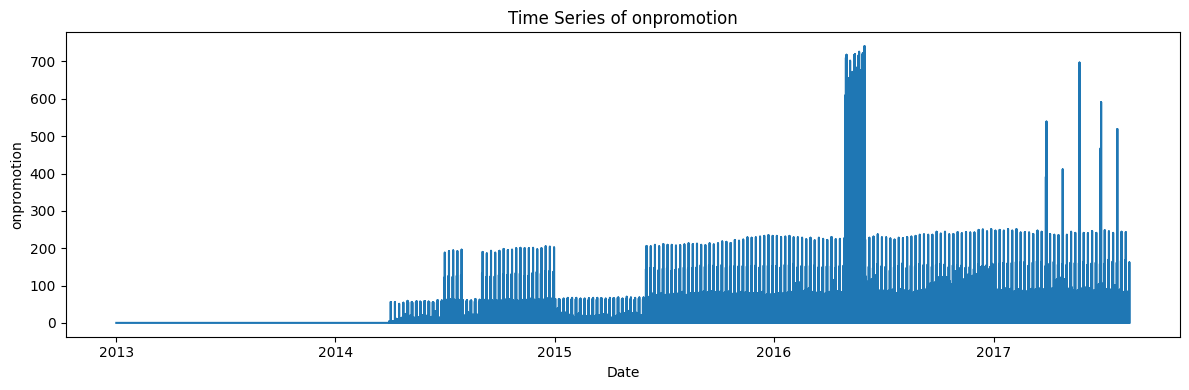

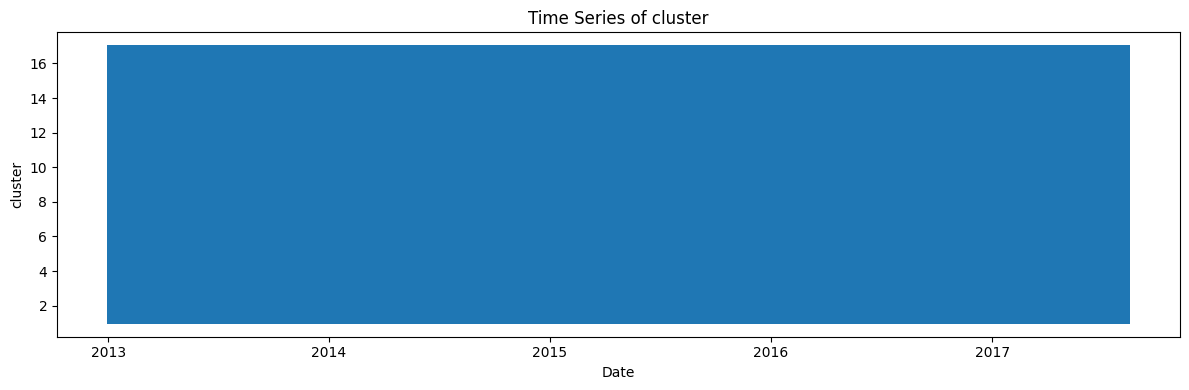

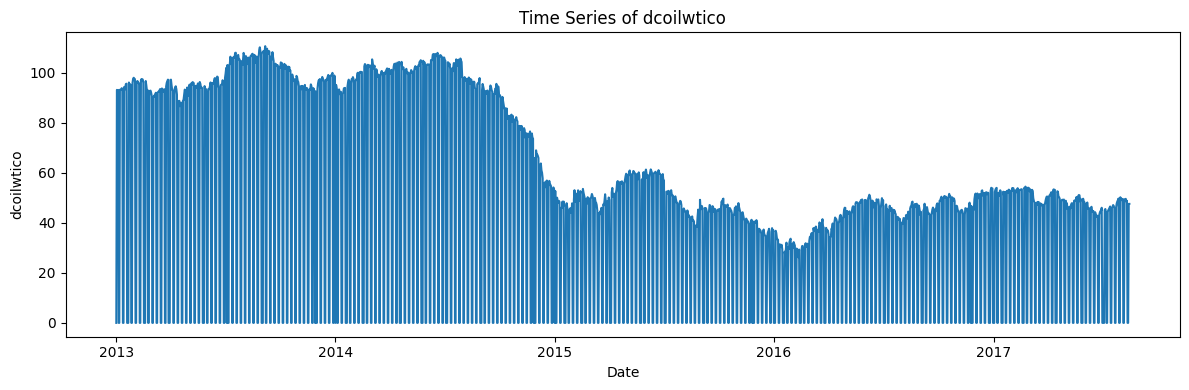

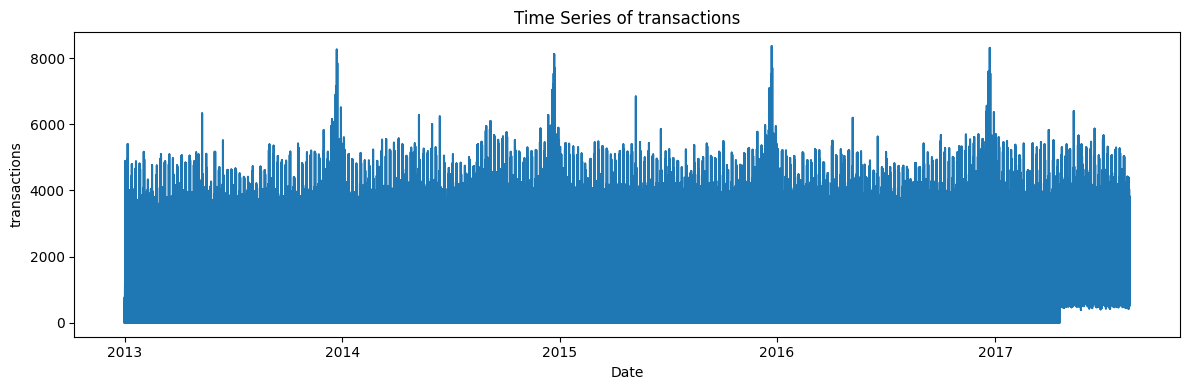

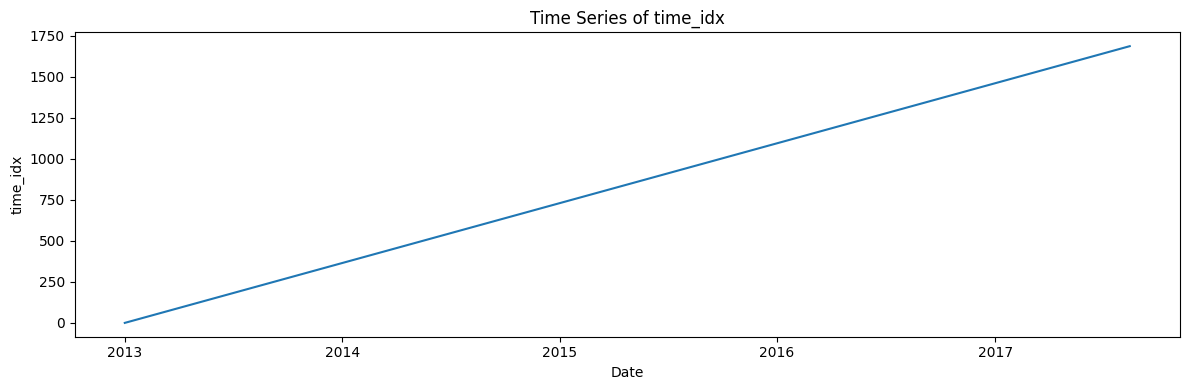

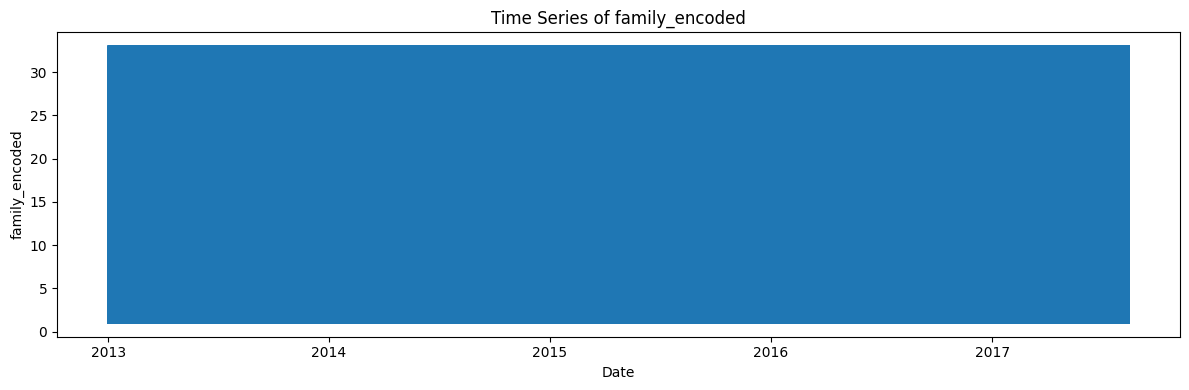

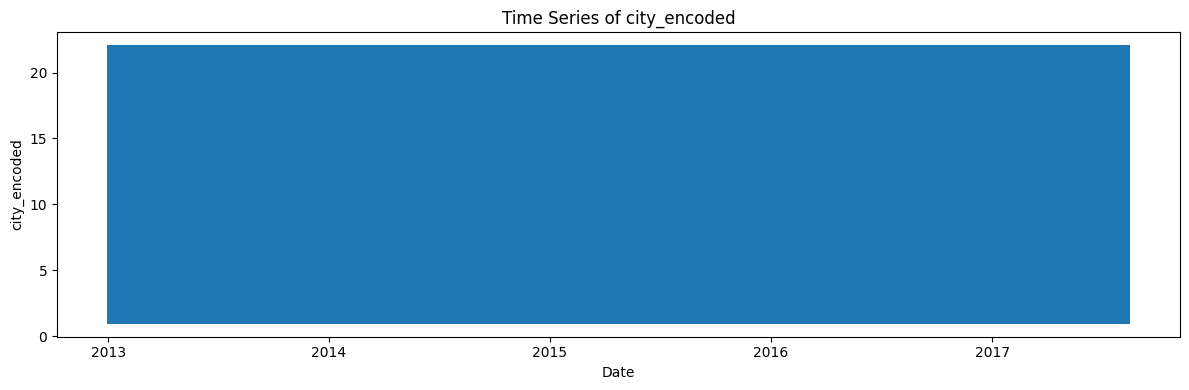

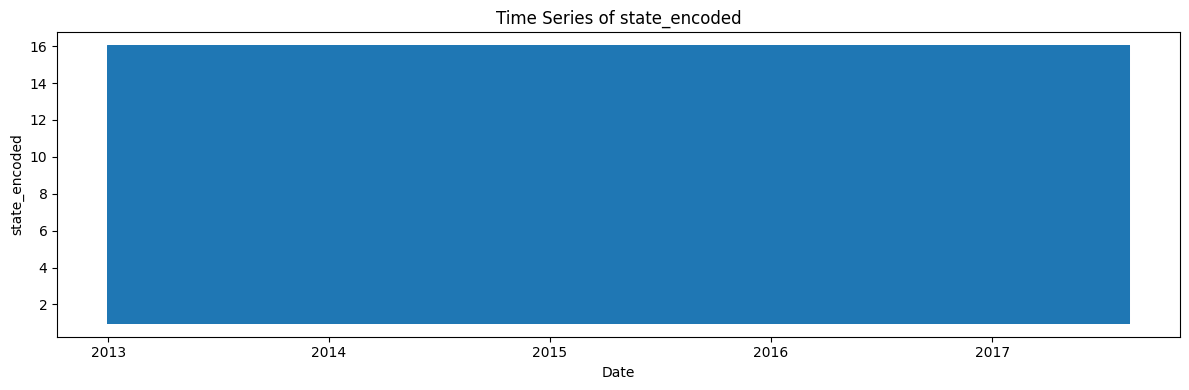

Only plotting first 10 columns.


In [37]:
plot_all_time_series(merged_df_final, num_cols_for_vis)

In [38]:
merged_df_final.head()

,store_nbr,sales,onpromotion,cluster,dcoilwtico,transactions,time_idx,family_encoded,city_encoded,state_encoded,type_x_encoded,type_y_encoded,locale_encoded,locale_name_encoded,description_encoded,transferred_encoded
date,,,,,,,,,,,,,,,,
2013-01-01,1,0.0,0,13,0.0,0.0,0,1,19,13,4,5,3,6,52,2
2013-01-01,1,0.0,0,13,0.0,0.0,0,2,19,13,4,5,3,6,52,2
2013-01-01,1,0.0,0,13,0.0,0.0,0,3,19,13,4,5,3,6,52,2
2013-01-01,1,0.0,0,13,0.0,0.0,0,4,19,13,4,5,3,6,52,2
2013-01-01,1,0.0,0,13,0.0,0.0,0,5,19,13,4,5,3,6,52,2


In [39]:
merged_df_final.columns

Index(['store_nbr', 'sales', 'onpromotion', 'cluster', 'dcoilwtico',
       'transactions', 'time_idx', 'family_encoded', 'city_encoded',
       'state_encoded', 'type_x_encoded', 'type_y_encoded', 'locale_encoded',
       'locale_name_encoded', 'description_encoded', 'transferred_encoded'],
      dtype='object')

### Data Preprocessing


In [ ]:
merged_df_final.reset_index(inplace=True)
min_date = merged_df_final['date'].min()
merged_df_final['time_idx'] = (merged_df_final['date'] - min_date).dt.days
merged_df_final['store_nbr'] = merged_df_final['store_nbr'].astype(str)
merged_df_final['type_x_encoded'] = merged_df_final['type_x_encoded'].astype(str)
merged_df_final['cluster'] = merged_df_final['cluster'].astype(str)


In [45]:
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = merged_df_final["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

In [50]:
training = TimeSeriesDataSet(
    
    merged_df_final,
    time_idx="time_idx",
    target="onpromotion",
    group_ids=["store_nbr"],
    min_encoder_length=14,  # keep encoder length short for speed
    max_encoder_length=14,
    min_prediction_length=20,
    max_prediction_length=20,
    static_categoricals=["store_nbr", "type_x_encoded", "cluster"],
    static_reals=["dcoilwtico"],
    time_varying_known_categoricals=["type_x_encoded"],
    time_varying_known_reals=["transactions"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["sales"],
    allow_missing_timesteps=True
)

In [69]:
validation = TimeSeriesDataSet.from_dataset(training, merged_df_final, min_prediction_idx=training_cutoff + 1)
batch_size = 32  # Even smaller batch size

# Create dataloaders with explicit handling of the last batch
train_dataloader = training.to_dataloader(
    train=True, 
    batch_size=batch_size, 
    num_workers=0,
    shuffle=True,
    drop_last=True  # Explicitly drop the last batch
)

val_dataloader = validation.to_dataloader(
    train=False, 
    batch_size=batch_size, 
    num_workers=0,
    shuffle=False,
    drop_last=True  # Explicitly drop the last batch
)

# Try prediction with CPU
baseline_predictions = Baseline().predict(
    val_dataloader, 
    trainer_kwargs=dict(accelerator="cpu"),
    return_y=True
)

# Calculate SMAPE
smape = SMAPE()(baseline_predictions.output, baseline_predictions.y)
print(f"SMAPE: {smape}")

/home/metaphysicist/Coding/2025/Projects/Time_Series/Sales_Ecuador/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/metaphysicist/Coding/2025/Projects/Time_Series/Sales_Ecuador/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/metaphysicist/Coding/2025/Projects/Time_Series/Sales_Ec

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 32 but got size 22 for tensor number 55 in the list.

In [68]:


# If you find inconsistent tensor sizes, you might need to adjust your batch size:
# Calculate the maximum possible batch size that works with your data
max_batch_size = min(len(validation) // 2, 32)  # Use a conservative estimate
batch_size = max_batch_size - (max_batch_size % 2)  # Make it even
print(f"Recommended batch size: {batch_size}")

# Recreate the dataloaders with the new batch size
val_dataloader = validation.to_dataloader(
    train=False, 
    batch_size=batch_size, 
    num_workers=0,
    shuffle=False
)

Recommended batch size: 32


In [71]:
# Check the data structure
print("\nData structure check:")
print("Columns in validation data:", validation.data.columns.tolist())
print("\nSample of validation data:")
print(validation.data.head())

# Check if store_nbr is properly set as a group
print("\nUnique store numbers:", validation.data["store_nbr"].nunique())
print("Store number distribution:")
print(validation.data["store_nbr"].value_counts().head())


Data structure check:


AttributeError: 'dict' object has no attribute 'columns'

### Modeling


### Training


### Testing
